In [1]:
import numpy as np
import math
import torch
import sys
from matplotlib import pyplot as plt
from matplotlib import colors as clrs

/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if sys.platform == "darwin":
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

mps


## Q 3.1

### Logistic Regression

In [3]:
# Create dataloaders
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, i):
        return self.data[i], self.labels[i]

class LinearLogisticRegression(torch.nn.Module):
    def __init__(self):
        super(LinearLogisticRegression, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(2, 1, bias=True),
            torch.nn.Sigmoid()
        )
        self.layers[0].state_dict()['weight'].zero_()
        return
    def forward(self, x):
        x = x.view(-1, 2)
        return self.layers(x)

class KernelLogisticRegression(torch.nn.Module):
    def __init__(self):
        super(LinearLogisticRegression, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(4, 1, bias=True),
            torch.nn.Sigmoid()
        )
        self.layers[0].state_dict()['weight'].zero_()
        return
    def forward(self, x):
        x = x.view(-1, 4)
        return self.layers(x)

class LinearSVM(torch.nn.Module):
    def __init__(self):
        super(LinearSVM, self).__init__()
        self.layers = torch.nn.Sequential(torch.nn.Linear(2, 1, bias=True))
        return

    def weights(self):
        return self.layers[0].state_dict()['weight']

    def forward(self, x):
        x = x.view(-1, 2)
        return self.layers(x)

class KernelSVM(torch.nn.Module):
    def __init__(self):
        super(KernelSVM, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(4, 1, bias=True),
            torch.nn.Sigmoid()
        )
        self.layers[0].state_dict()['weight'].zero_()
        return
    def forward(self, x):
        x = x.view(-1, 4)
        return self.layers(x)

def run_knn(k, X_train, Y_train, X_test):
    distances = -2*(X_test@X_train.T) + \
                torch.sum(torch.square(X_train), axis=1) + \
                torch.sum(torch.square(X_test), axis=1).unsqueeze_(-1)
    sorted_indices = torch.argsort(distances, axis = 1)[:, :k]
    knn = Y_train[sorted_indices].int()
    return knn

## Q 3.2

In [4]:
# Create Dataset
mu = torch.tensor([2.5, 0])
a  = []
b = []
positive_example_sampler = torch.distributions.MultivariateNormal(mu, torch.eye(2))
negative_example_sampler = torch.distributions.MultivariateNormal(-mu, torch.eye(2))
for _ in range(750):
    a.append(positive_example_sampler.sample().view(1,2))
    b.append(negative_example_sampler.sample().view(1,2))

postive_data_points = torch.stack(a).view(750, 2)
negative_data_points = torch.stack(b).view(750, 2)
data_set = torch.cat((postive_data_points, negative_data_points))
labels = torch.cat((torch.ones(750, 1), torch.zeros(750, 1)))
shuffle_index = torch.randperm(data_set.shape[0])
data_set = data_set[shuffle_index]
labels = labels[shuffle_index]
permuted_indices = torch.randperm(data_set.shape[0])
training_data = data_set[permuted_indices[:1000]]
training_labels = labels[permuted_indices[:1000]]
validation_data = data_set[permuted_indices[1000:1250]]
validation_labels = labels[permuted_indices[1000:1250]]
test_data = data_set[permuted_indices[1250:1500]]
test_labels = labels[permuted_indices[1250:1500]] 

training_set = Dataset(training_data, training_labels)
train_loader = torch.utils.data.DataLoader(training_set, shuffle=True, batch_size=256)
validation_set = Dataset(validation_data, validation_labels)
validation_loader = torch.utils.data.DataLoader(validation_set, shuffle=True, batch_size=250)
test_set = Dataset(test_data, test_labels)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=250)

In [31]:
def get_prediction(model, data):
    return model(data).detach()

def get_accuracy(predictions, labels):
    threshold = torch.tensor([0.5])
    predictions = (predictions >= threshold).float()*1
    return float(torch.count_nonzero((labels == predictions)))/float(len(labels))

def report_acc_decision_boundary(model, test_set_loader):
    for data, labels in test_set_loader:
        predictions = get_prediction(model, data)
        accuracy = get_accuracy(predictions, labels)
        print(f" Accuracy of model on test set: {accuracy*100}%")
    return

def draw_decision_boundary(model, test_dataset):
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes()

    x_min, x_max = test_set.data.min() - 1, test_set.data.max() + 1
    y_min, y_max = test_set.data.min() - 1, test_set.data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01).astype(np.float32),
                        np.arange(y_min, y_max, 0.01).astype(np.float32))
    preds = get_prediction(model, torch.hstack((torch.from_numpy(xx.ravel()).view(len(xx.ravel()), 1), torch.from_numpy(yy.ravel()).view(len(xx.ravel()), 1))))
    threshold = torch.tensor([0.5])
    preds = (preds >= threshold).float()*1
    preds = preds.reshape(xx.shape)
    plt.contourf(xx, yy, preds, cmap='Paired_r', alpha=0.5)
    plt.contour(xx, yy, preds, colors='k', linewidths=0.7)

    ax.scatter(test_dataset.data[:, 0], test_dataset.data[:, 1], c=test_dataset.labels ,cmap = clrs.ListedColormap(["red", "blue"]))
    plt.title("Decision Boundary")

    plt.show()
    return

def train_logistic_regression(model, train_loader, validation_loader, learning_rate, losses, debug=False):
    criterion = torch.nn.BCELoss(reduction='mean')
    threshold = 1e-4
    loss_reduction = 1.0
    optim = torch.optim.SGD(model.parameters(), learning_rate)
    prev_loss = math.inf
    curr_loss = math.inf
    epoch = 1

    while loss_reduction >= threshold:
        for x, y in train_loader:
            # Train model on training set
            y_hat = model(x)
            loss = criterion(y_hat, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            loss_reduction = abs(loss.item()/prev_loss - 1.0)
            prev_loss = loss.item()
            losses.append(prev_loss)
        if debug:
            print(f"Loss reduction after {epoch} epochs: {loss_reduction}")
        epoch += 1

    # Evaluate on validation set
    validation_accuracy = 0.
    for val_data, val_labels in validation_loader:
        val_predictions = get_prediction(model, val_data).view(val_data.shape[0], 1)
        validation_accuracy = get_accuracy(val_predictions, val_labels)
    print(f" Validation Set accuracy is: {validation_accuracy*100}")
    
    return

def train_linear_svm(model, train_loader, validation_loader, learning_rate, reg_param, losses, debug=False):
    threshold = 1e-4
    loss_reduction = 1.0
    optim = torch.optim.SGD(model.parameters(), learning_rate)
    prev_loss = math.inf
    curr_loss = math.inf
    
    epoch = 1
    while loss_reduction >= threshold:
        for x, y in train_loader:
            # Train model on training set
            y_hat = model(x).view(x.shape[0], 1)
            #Get weights of the linear layer
            params = model.weights()
            loss = reg_param * torch.mean(torch.clamp(1 -  (2*y - 1)  * y_hat, min=0))
            loss += torch.sum(torch.sum(params)) / 2.0
            optim.zero_grad()
            loss.backward()
            optim.step()
            loss_reduction = abs(loss.item()/prev_loss - 1.0)
            prev_loss = loss.item()
            losses.append(prev_loss)
        if debug:
            print(f"Loss reduction after {epoch} epochs: {loss_reduction}")
        epoch +=1

    # Evaluate on validation set
    validation_accuracy = 0.
    for val_data, val_labels in validation_loader:
        val_predictions = get_prediction(model, val_data).view(val_data.shape[0], 1)
        validation_accuracy = get_accuracy(val_predictions, val_labels)
    print(f" Validation Set accuracy is: {validation_accuracy*100}")
    
    return


### Q 3.2.1

#### Logistic Regression - Report Accuracy and draw Decision Boundary

In [34]:
# Train model
linear_lr_model = LinearLogisticRegression()
losses = []
train_logistic_regression(linear_lr_model, train_loader, validation_loader, 0.05, losses)

 Validation Set accuracy is: 99.6


 Accuracy of model on test set: 99.2%


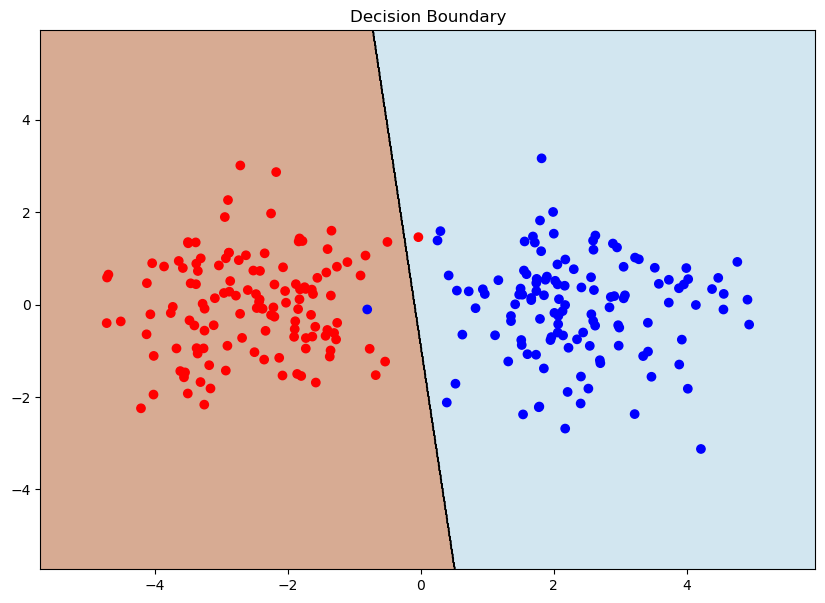

In [35]:
#Report Accuracy
report_acc_decision_boundary(linear_lr_model, test_loader)

#Draw - decision boundary
draw_decision_boundary(linear_lr_model, test_set)

#### Linear SVM

In [36]:
linear_svm_model = LinearSVM()
losses = []
reg_param = 2.0
step_size = 0.05
train_linear_svm(linear_svm_model, train_loader, validation_loader, step_size, reg_param, losses, debug=True)


Loss reduction after 1 epochs: 0.3404702850395135
Loss reduction after 2 epochs: 0.07118038694076223
Loss reduction after 3 epochs: 0.10746879938575349
Loss reduction after 4 epochs: 0.04678979702551711
Loss reduction after 5 epochs: 0.011829863534466023
Loss reduction after 6 epochs: 0.07780866157177024
Loss reduction after 7 epochs: 0.006902605571164067
Loss reduction after 8 epochs: 0.05306736081462171
Loss reduction after 9 epochs: 0.007062658077830797
Loss reduction after 10 epochs: 0.0689980111849724
Loss reduction after 11 epochs: 0.118278505478709
Loss reduction after 12 epochs: 0.016649840590874376
Loss reduction after 13 epochs: 0.01762479180606058
Loss reduction after 14 epochs: 0.03287624476728501
Loss reduction after 15 epochs: 0.024431458746002055
Loss reduction after 16 epochs: 0.030522408649618082
Loss reduction after 17 epochs: 0.07353765903541598
Loss reduction after 18 epochs: 0.003044098533159678
Loss reduction after 19 epochs: 0.025352997904271257
Loss reduction af

 Accuracy of model on test set: 99.2%


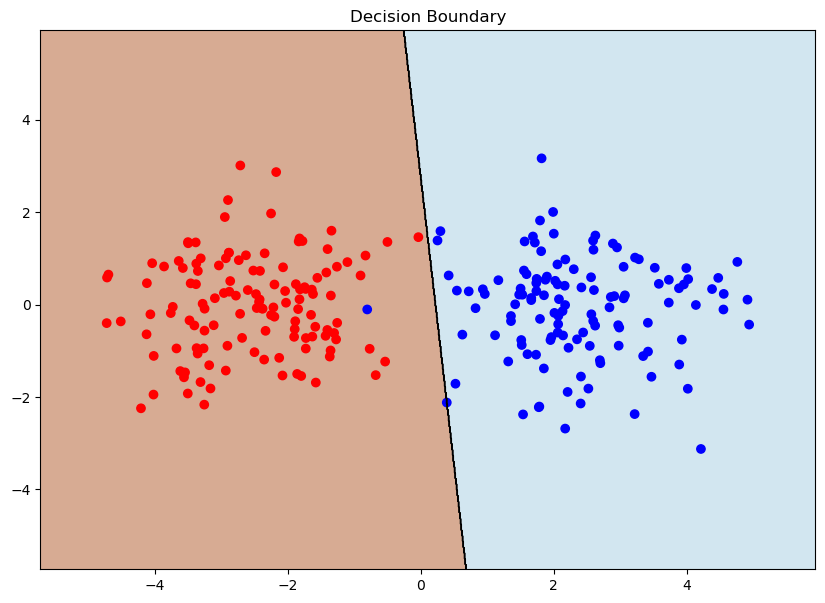

In [37]:
#Report Accuracy
report_acc_decision_boundary(linear_svm_model, test_loader)

#Draw - decision boundary
draw_decision_boundary(linear_svm_model, test_set)

### Q 3.2.2

#### Naives Bayes Classifier

In [38]:
from sklearn.naive_bayes import GaussianNB

def draw_decision_boundary_for_sklearn(model, test_dataset):
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes()

    x_min, x_max = test_set.data.min() - 1, test_set.data.max() + 1
    y_min, y_max = test_set.data.min() - 1, test_set.data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01).astype(np.float32),
                        np.arange(y_min, y_max, 0.01).astype(np.float32))

    preds = model.predict(np.concatenate((xx.ravel().reshape(len(xx.ravel()), 1), yy.ravel().reshape(len(yy.ravel()), 1)), axis=1).reshape(len(yy.ravel()), 2))
    preds = preds >= 0.5*1.0
    preds = preds.reshape(xx.shape)
    plt.contourf(xx, yy, preds, cmap='Paired_r', alpha=0.5)
    plt.contour(xx, yy, preds, colors='k', linewidths=0.7)

    ax.scatter(test_dataset.data[:, 0], test_dataset.data[:, 1], c=test_dataset.labels ,cmap = clrs.ListedColormap(["red", "blue"]))
    plt.title("Decision Boundary")

    plt.show()
    return

naive_bayes_model = GaussianNB()
naive_bayes_model.fit(training_data, training_labels)
val_predictions = naive_bayes_model.predict(validation_data)
print(f"Validation Set Accuracy of Gaussian Naive Bayes classifier: \
    {float(torch.count_nonzero(validation_labels == torch.from_numpy(val_predictions).view(-1, 1)))/float(validation_data.shape[0])*100}")



Validation Set Accuracy of Gaussian Naive Bayes classifier:     99.2


/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


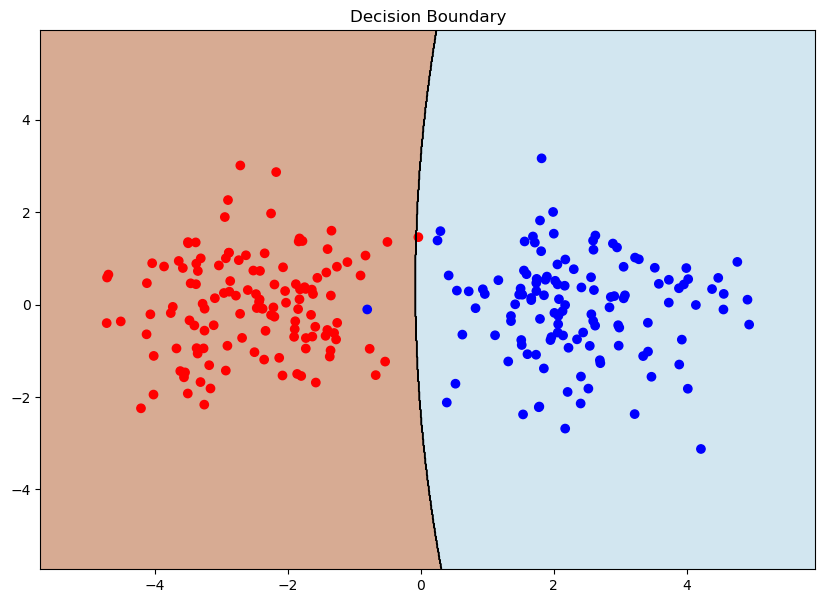

 Accuracy of model on test set: 99.2%


In [39]:
naive_bayes_test_predictions = naive_bayes_model.predict(test_data)

draw_decision_boundary_for_sklearn(naive_bayes_model, test_set)
naive_bayes_acc = get_accuracy(torch.from_numpy(naive_bayes_test_predictions).view(-1, 1), test_labels)
print(f" Accuracy of model on test set: {naive_bayes_acc*100}%")

#### KNN Decision Boundary and Accuracy

In [41]:
from sklearn import neighbors

knn_model = neighbors.KNeighborsClassifier(n_neighbors=3)

knn_model.fit(training_data, training_labels)

val_predictions = knn_model.predict(validation_data)
print(f"Validation Set Accuracy of KNN classifier: \
    {float(torch.count_nonzero(validation_labels == torch.from_numpy(val_predictions).view(-1, 1)))/float(validation_data.shape[0])*100}")

Validation Set Accuracy of KNN classifier:     99.2


/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


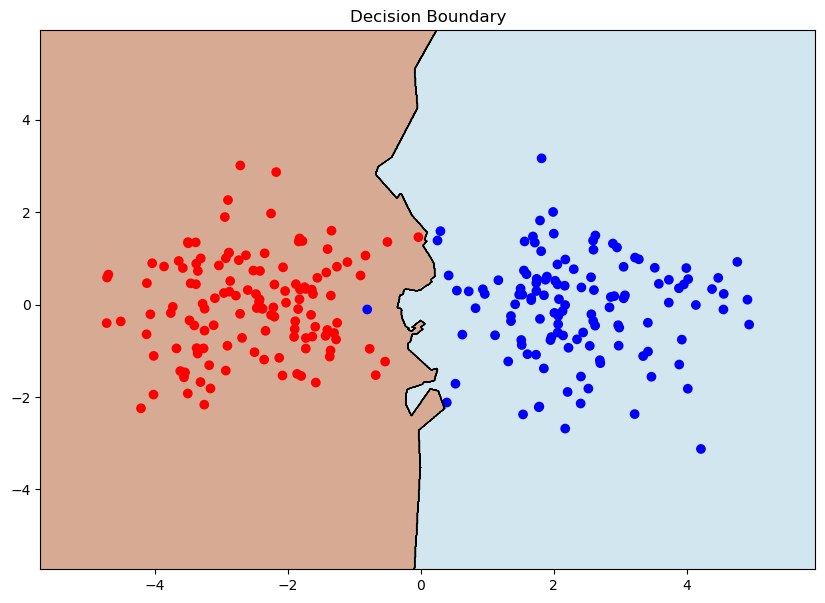

 Accuracy of model on test set: 99.6%


In [43]:
knn_test_predictions = knn_model.predict(test_data)

draw_decision_boundary_for_sklearn(knn_model, test_set)
knn_acc = get_accuracy(torch.from_numpy(knn_test_predictions).view(-1, 1), test_labels)
print(f" Accuracy of model on test set: {knn_acc*100}%")

### Q 3.2.3

In [45]:
mu_step_size = 0.20
mu = 1.0
losses = {}
losses["LinearRegression"] = []
losses["LinearSVM"] = []
losses["NaiveBayes"] = []
losses["KNN"] = []
x_axis = []

while mu <= 2.4:
    mu_tensor = torch.tensor([mu, 0])
    a  = []
    b = []
    positive_example_sampler = torch.distributions.MultivariateNormal(mu_tensor, torch.eye(2))
    negative_example_sampler = torch.distributions.MultivariateNormal(-mu_tensor, torch.eye(2))
    for _ in range(750):
        a.append(positive_example_sampler.sample().view(1,2))
        b.append(negative_example_sampler.sample().view(1,2))

    postive_data_points = torch.stack(a).view(750, 2)
    negative_data_points = torch.stack(b).view(750, 2)
    data_set = torch.cat((postive_data_points, negative_data_points))
    labels = torch.cat((torch.ones(750, 1), torch.zeros(750, 1)))
    shuffle_index = torch.randperm(data_set.shape[0])
    data_set = data_set[shuffle_index]
    labels = labels[shuffle_index]
    permuted_indices = torch.randperm(data_set.shape[0])
    training_data = data_set[permuted_indices[:1000]]
    training_labels = labels[permuted_indices[:1000]]
    validation_data = data_set[permuted_indices[1000:1250]]
    validation_labels = labels[permuted_indices[1000:1250]]
    test_data = data_set[permuted_indices[1250:1500]]
    test_labels = labels[permuted_indices[1250:1500]] 

    training_set = Dataset(training_data, training_labels)
    train_loader = torch.utils.data.DataLoader(training_set, shuffle=True, batch_size=256)
    validation_set = Dataset(validation_data, validation_labels)
    validation_loader = torch.utils.data.DataLoader(validation_set, shuffle=True, batch_size=250)
    test_set = Dataset(test_data, test_labels)
    test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=250)
    
    linear_lr_model = LinearLogisticRegression()
    linear_svm_model = LinearSVM()
    naive_bayes_model = GaussianNB()
    knn_model = neighbors.KNeighborsClassifier(n_neighbors=3)
    l = []
    train_logistic_regression(linear_lr_model, train_loader, validation_loader, 0.05, l)
    train_linear_svm(linear_svm_model, train_loader, validation_loader, 0.05, 2.5, l)
    naive_bayes_model.fit(training_data, training_labels)
    knn_model.fit(training_data, training_labels)
    
    losses["LinearRegression"].append(get_accuracy(get_prediction(linear_lr_model, test_data), test_labels))
    losses["LinearSVM"].append(get_accuracy(get_prediction(linear_svm_model, test_data), test_labels))
    losses["NaiveBayes"].append(get_accuracy(torch.from_numpy(naive_bayes_model.predict(test_data)).view(-1, 1), test_labels))
    losses["KNN"].append(get_accuracy(torch.from_numpy(knn_model.predict(test_data)).view(-1, 1), test_labels))
    x_axis.append(mu)
    mu += mu_step_size
    
    

 Validation Set accuracy is: 81.6
 Validation Set accuracy is: 81.2


/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


 Validation Set accuracy is: 90.0
 Validation Set accuracy is: 88.4


/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


 Validation Set accuracy is: 92.4
 Validation Set accuracy is: 92.80000000000001


/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


 Validation Set accuracy is: 95.19999999999999
 Validation Set accuracy is: 92.80000000000001


/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


 Validation Set accuracy is: 96.39999999999999
 Validation Set accuracy is: 96.0


/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


 Validation Set accuracy is: 97.2
 Validation Set accuracy is: 97.2


/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


 Validation Set accuracy is: 99.6
 Validation Set accuracy is: 98.0


/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


 Validation Set accuracy is: 99.2
 Validation Set accuracy is: 98.4


/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


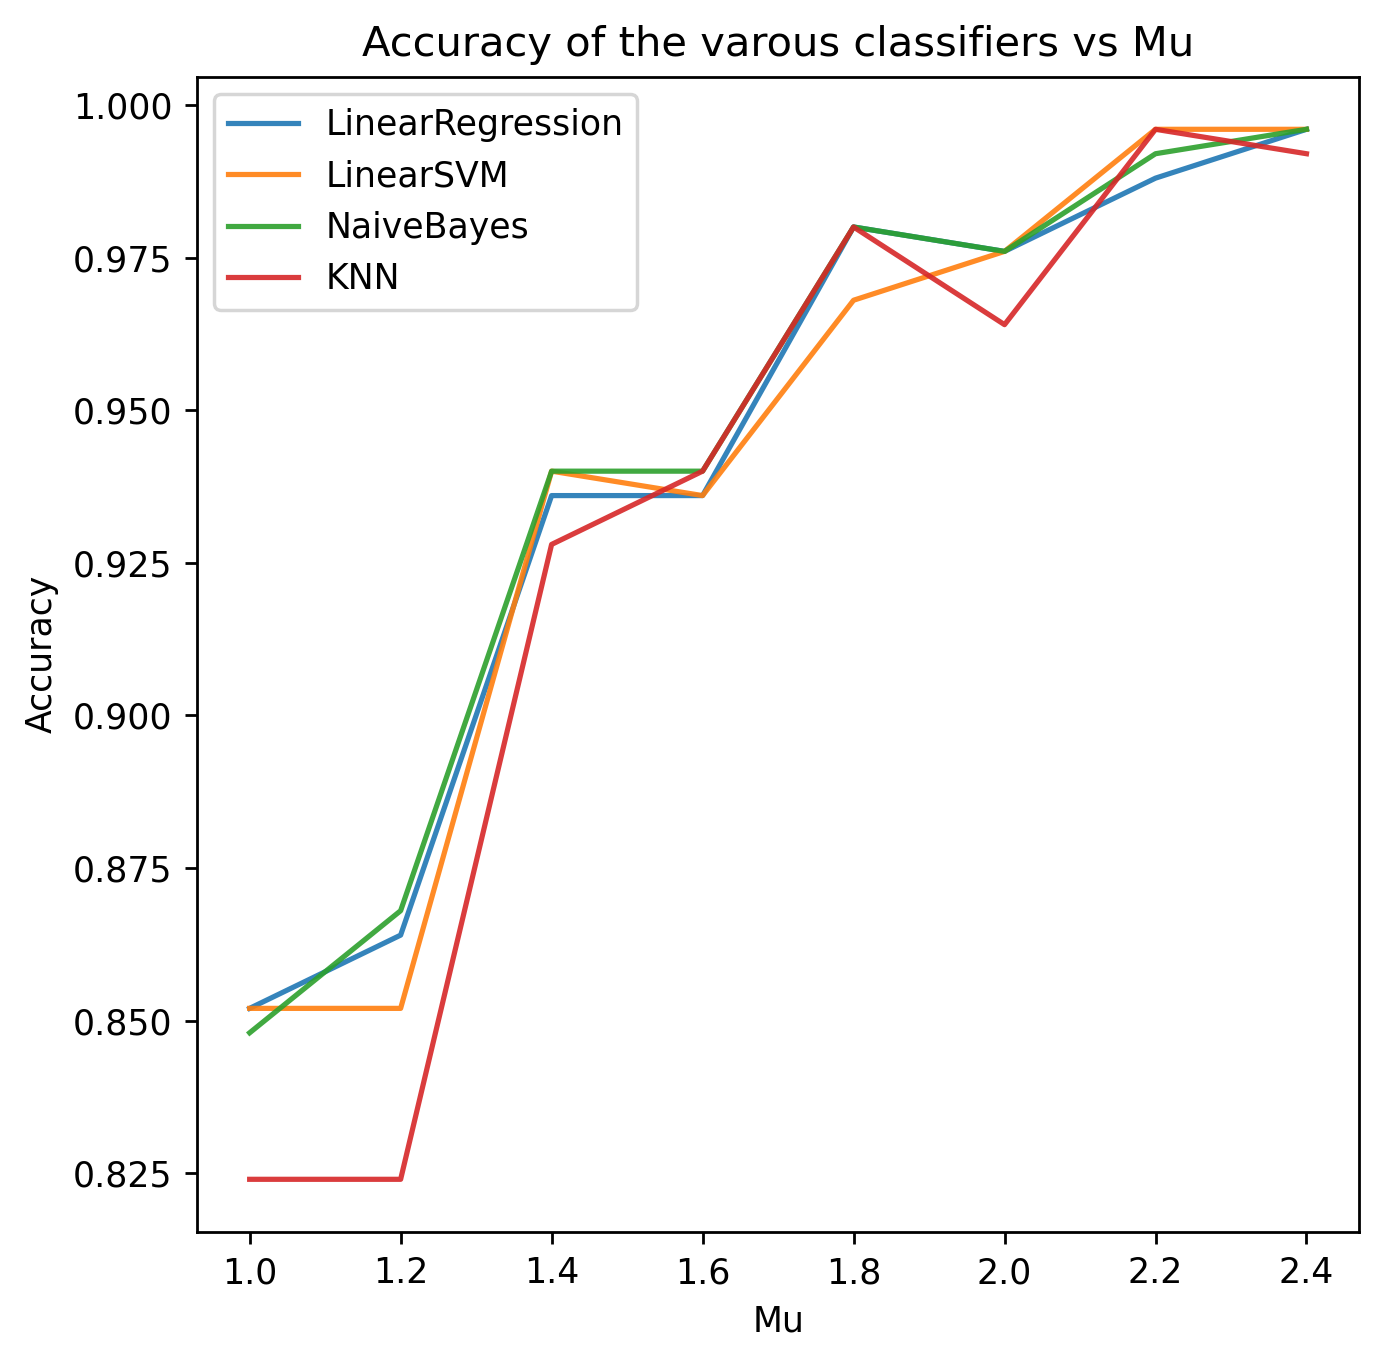

In [61]:
models = ["LinearRegression", "LinearSVM", "NaiveBayes", "KNN"]
colors = ['purple', 'yellow', 'red', 'teal']
fig = plt.figure(figsize=(6, 6), dpi=250)

ax = plt.axes()
ax.set_title("Accuracy of the varous classifiers vs Mu")
ax.set_xlabel("Mu")
ax.set_ylabel("Accuracy")

for i, model in enumerate(models):
    ax.plot(x_axis, losses[model], label=model, alpha=0.90)
plt.legend(loc="upper left")
plt.show()    

## Q 3.3

In [62]:
from sklearn import datasets

In [63]:
data_set_tuples = datasets.make_circles(1500)

data_set = torch.zeros((len(data_set_tuples[0]), 2), dtype=torch.float)
labels = torch.zeros((len(data_set_tuples[0]), 1), dtype=torch.float)
data_set.copy_(torch.from_numpy(data_set_tuples[0].astype(np.float32)))
labels.copy_(torch.from_numpy(data_set_tuples[1].astype(np.float32)).view((len(data_set_tuples[0]), 1)))
permuted_indices = torch.randperm(data_set.shape[0])
training_data = data_set[permuted_indices[:1000]]
training_labels = labels[permuted_indices[:1000]]
validation_data = data_set[permuted_indices[1000:1250]]
validation_labels = labels[permuted_indices[1000:1250]]
test_data = data_set[permuted_indices[1250:1500]]
test_labels = labels[permuted_indices[1250:1500]]

training_set = Dataset(training_data, training_labels)
train_loader = torch.utils.data.DataLoader(training_set, shuffle=True, batch_size=256)
validation_set = Dataset(validation_data, validation_labels)
validation_loader = torch.utils.data.DataLoader(validation_set, shuffle=True, batch_size=250)
test_set = Dataset(test_data, test_labels)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=250)

#### Linear Regression Model

 Validation Set accuracy is: 48.0
 Accuracy of model on test set: 47.599999999999994%


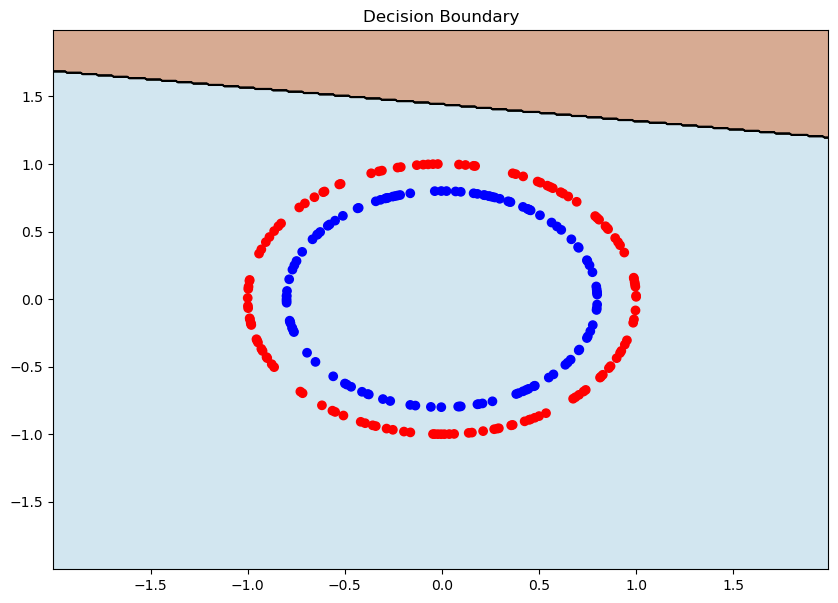

In [64]:
linear_lr_model = LinearLogisticRegression()
losses = []
train_logistic_regression(linear_lr_model, train_loader, validation_loader, 0.05, losses)

#Accuracy
report_acc_decision_boundary(linear_lr_model, test_loader)

#Decision Boundary
draw_decision_boundary(linear_lr_model, test_set)

#### Linear SVM Model

 Validation Set accuracy is: 50.4
 Accuracy of model on test set: 51.2%


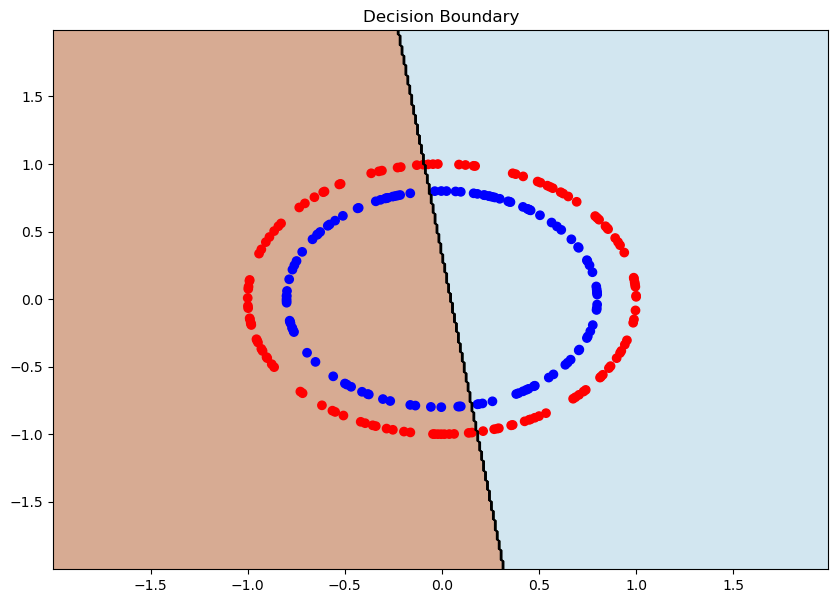

In [65]:
linear_svm_model = LinearSVM()
losses = []
reg_param = 1.5
step_size = 0.05
train_linear_svm(linear_svm_model, train_loader, validation_loader, step_size, reg_param, losses)

#Accuracy
report_acc_decision_boundary(linear_svm_model, test_loader)

#Decision Boundary
draw_decision_boundary(linear_svm_model, test_set)